In [2]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'vroom'


The following objects are masked from 'package:readr':

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_names,
    date_names_lang, date_names_langs, default_locale, fwf_cols,
    fwf_empty, fwf_positions, fwf_widths, locale, output_column,
    problems, spec


Registered S3 method overwritten by 'q

In [3]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')


- import price index
- elasticity of import demand (2%)
- indeed real time wage inflation
- reliability of data? 
- harvard pricing lab
- eric santor
- 

In [4]:
all_tarrif_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-Export.csv")

general_import_charges <- all_tarrif_data|>
filter(`Data Type` == "General Import Charges")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()

general_customs_value <- all_tarrif_data|>
filter(`Data Type` == "General Customs Value")|>
dplyr::select(Year, Month, `General Customs Value`)|>
rename(VALUE = `General Customs Value`)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()



tarrif_rate_df <- inner_join(
  general_import_charges, 
  general_customs_value, 
  by = "Date",
  suffix = c("_charges", "_value")
) |>
  
  # 2. Calculate the approximate tariff rate using the two VALUE columns
  mutate(
    Approximate_Rate = (VALUE_charges / VALUE_value) * 100
  ) |>
  rename(month = Date)|>
  # 3. Keep only the columns you need for your VAR model
  dplyr::select(month, Approximate_Rate)

# --- Check the final result ---
glimpse(tarrif_rate_df)

Rows: 616 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Data Type, Year, Month, General Customs Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 269869762, 278547963, 305301730, 290530227, 301763964, 297764412…
Rows: 306
Columns: 2
$ Date  <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000-05-01, 200…
$ VALUE <dbl> 17705142820, 18087403941, 20618285791, 18506995213, 19558432594,…
Rows: 306
Columns: 2
$ month            <date> 2000-01-01, 2000-02-01, 2000-03-01, 2000-04-01, 2000…
$ Approximate_Rate <dbl> 1.524245, 1.540011, 1.480733, 1.569840, 1.542884, 1.4…


In [5]:

### EXCHANGE RATE US-CANADA ###
exc_rate <- fredr(
  series_id = "DEXCAUS",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)

### TRADE COMMODITIES US-CANADA ###
trade_commodities <- fredr(
  series_id = "XTNTVA01CAM664S",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)


### TRADE POLICY UNCERTAINTY INDEX ###
tpu_data <- read_csv("Categorical_EPU_Data.csv")|>
mutate(Date = ymd(paste(Year, Month, "01", sep = "-")))|>
rename(VALUE = '9. Trade policy')|>
glimpse()


### lFS MICRO ###
lfs_micro <- read_csv('C:/Users/Irene/governorschallenge/INDINF_WAGES_MONTHLY.csv', skip=20)|>
dplyr::select(date, INDINF_LFSMICRO_M)|>
rename(Date = date, VALUE = INDINF_LFSMICRO_M)|>
  mutate(Date = mdy(Date)) |>
  filter(Date > ymd("2000-12-31"))|>
glimpse()

### SURVEY - ABILITY TO MEET PRODUCTION DEMAND ###

# ppc_data <- read_csv('C:/Users/Irene/governorschallenge/CAPACITYSIGNIF,CAPACITYSOME-sd-1999-07-01-ed-2025-07-01.csv', skip = 9) |>
#   dplyr::select(date, CAPACITYSIGNIF) |>
#   rename(Date = date, VALUE = CAPACITYSIGNIF) |>
#   # Use yq() to correctly parse the "Year-Quarter" format
#   mutate(Date = yq(Date)) |>
#   filter(Date > ymd("2000-12-31"))

# Add refresh = TRUE to each call to bypass the cache
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300, refresh = TRUE)
cpi_vec <- get_cansim_vector_for_latest_periods("v108785715", periods = 500, refresh = TRUE) # CHANGE IN CPI
# exc_vec <- get_cansim_vector_for_latest_periods("v111666275", periods = 300, refresh = TRUE)
# oil_vec <- get_cansim_vector_for_latest_periods('v1352087861', periods = 600, refresh = TRUE)
unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500, refresh = TRUE) # UNEMPLOYMENT RATE
# ulc_vec <- get_cansim_vector_for_latest_periods('v29509282', periods = 300, refresh = TRUE) 
fcpi_vec <- get_cansim_vector_for_latest_periods('v52673496', periods = 500, refresh = TRUE) ## FISHER COMMODITY PRICE INDEX

wti_price_monthly <- fredr::fredr(series_id = "MCOILWTICO") ## CRUDE OUL PRICES -- WEST TEXAS INTERMEDIATE

# The data goes back to 1986
print(head(wti_price_monthly))

Rows: 488 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Year
dbl (2): Month, 9. Trade policy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Date = ymd(paste(Year, Month, "01", sep = "-"))`.
Caused by warning:
!  1 failed to parse."


Rows: 488
Columns: 4
$ Year  <chr> "1985", "1985", "1985", "1985", "1985", "1985", "1985", "1985", …
$ Month <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9…
$ VALUE <dbl> 122.61396, 41.76222, 107.92573, 194.75287, 124.39166, 153.16361,…
$ Date  <date> 1985-01-01, 1985-02-01, 1985-03-01, 1985-04-01, 1985-05-01, 198…


Rows: 390 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): date
dbl (7): INDINF_LFSMICRO_M, INDINF_LFSMICRO_LEVELS_M, INDINF_LFSWC_M, INDINF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 2
$ Date  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 200…
$ VALUE <dbl> 2.8, 3.3, 3.4, 3.3, 3.6, 3.3, 3.3, 3.1, 3.0, 3.0, 3.2, 3.4, 3.2,…


Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



# A tibble: 6 × 5
  date       series_id  value realtime_start realtime_end
  <date>     <chr>      <dbl> <date>         <date>      
1 1986-01-01 MCOILWTICO  22.9 2025-08-22     2025-08-22  
2 1986-02-01 MCOILWTICO  15.5 2025-08-22     2025-08-22  
3 1986-03-01 MCOILWTICO  12.6 2025-08-22     2025-08-22  
4 1986-04-01 MCOILWTICO  12.8 2025-08-22     2025-08-22  
5 1986-05-01 MCOILWTICO  15.4 2025-08-22     2025-08-22  
6 1986-06-01 MCOILWTICO  13.4 2025-08-22     2025-08-22  


In [6]:
## BREAK EVEN INFLATION RATE

monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553',periods = 500)
monthly_convetional_bond <- get_cansim_vector_for_latest_periods('v122543',periods = 500)
monthly_real_return_bond <- monthly_real_return_bond|>
dplyr::select(Date, VALUE)

monthly_convetional_bond <- monthly_convetional_bond|>
dplyr::select(Date, VALUE)

break_even_df <- monthly_convetional_bond |>
  inner_join(monthly_real_return_bond, by = "Date", suffix = c("_conventional", "_real_return")) |>
  mutate(break_even_inflation_rate = VALUE_conventional - VALUE_real_return) |>
  dplyr::select(Date, break_even_inflation_rate)

  glimpse(
break_even_df)

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



Rows: 500
Columns: 2
$ Date                      <date> 1984-01-01, 1984-02-01, 1984-03-01, 1984-04…
$ break_even_inflation_rate <dbl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …


In [7]:
policy_rate_daily_vec <- get_cansim_vector("v39050", start_time = "2000-01-01")

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Toronto'"


Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/Los_Angeles'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'GMT'"
Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone 'America/New_York'"
Accessing CANSIM NDM vectors from Statistics Canada



In [8]:
start_date <- "1990-01-01"

# # --- GDP ---
gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column and filter
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Calculate month-over-month percent change
  dplyr::mutate(
    delta_gdp = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  tidyr::drop_na()

# --- Break-even Inflation Rate ---
bond_monthly <- break_even_df |>
  dplyr::select(Date, break_even_inflation_rate) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_bond = (log(break_even_inflation_rate) - log(dplyr::lag(break_even_inflation_rate, 1))) * 100
  ) |>
  dplyr::select(month, delta_bond) |>
  tidyr::drop_na()

# ppc_monthly <- ppc_data |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ppc = VALUE
#   ) |>
#   dplyr::select(month, delta_ppc) |>
#   tidyr::drop_na()


# --- Policy Interest Rate (Level) ---
policy_rate_monthly <- policy_rate_daily_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column to group by
  mutate(month = floor_date(Date, "month")) |>
  # Group by month and calculate the average rate
  group_by(month) |>
  summarise(
    policy_rate = mean(VALUE, na.rm = TRUE) # Calculate the monthly average
  ) |>
  mutate(policy_rate  = (log(policy_rate) - log(dplyr::lag(policy_rate, 1))) * 100) |>
  ungroup()

# --- Oil ---
oil_monthly <- wti_price_monthly |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_oil = (log(value) - log(dplyr::lag(value, 1))) * 100
  ) |>
  dplyr::select(month, delta_oil) |>
  tidyr::drop_na()

trade_unc_monthly <- tpu_data |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    delta_trade_unc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_trade_unc) |>
  tidyr::drop_na()

# --- No changes needed for your inflation calculation ---
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(
    delta_inflation =  VALUE
  ) |>
  dplyr::select(month, delta_inflation) |>
  tidyr::drop_na()

fcpi_monthly <- fcpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(
    delta_fcpi = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_fcpi) |>
  tidyr::drop_na()|>
  glimpse()

# --- ULC (if you decide to use it, assuming it's monthly) ---
# ulc_monthly <- ulc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
#   dplyr::filter(month >= start_date) |>
#   dplyr::mutate(
#     delta_ulc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(month, delta_ulc) |>
#   tidyr::drop_na()

# Process CPI (monthly percent change)
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::mutate(
    delta_cpi = VALUE) |>
  dplyr::select(month, delta_cpi) |>
  tidyr::drop_na()

trade_commodities_monthly <- trade_commodities |>
  dplyr::select(date, value) |>
  dplyr::mutate(month = date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    trade_us_canada = value) |>
  dplyr::select(month, trade_us_canada ) |>
  tidyr::drop_na()

lfs_micro_monthly <- lfs_micro |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    lfs_micro = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100) |>
  dplyr::select(month, lfs_micro) |>
  tidyr::drop_na()

# Process Exchange Rate (quarterly percent change)
# exc_quarterly <- exc_vec |>
#   dplyr::select(Date, VALUE) |>
#   dplyr::mutate(quarter = lubridate::floor_date(Date, "quarter")) |>
#   dplyr::group_by(quarter) |>
#   dplyr::summarise(VALUE = dplyr::last(VALUE), .groups = 'drop') |>
#   dplyr::filter(quarter >= start_date) |> #
#   dplyr::mutate(
#     delta_exc = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
#   ) |>
#   dplyr::select(quarter, delta_exc) |>
#   tidyr::drop_na()

# Process Unemployment (using the rate level)
unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Using the unemployment rate level directly
  dplyr::mutate(
    delta_unemp = VALUE
  ) |>
  dplyr::select(month, delta_unemp) |>
  tidyr::drop_na()


exc_monthly <- exc_rate |>
rename(month = date)|>
rename(delta_exc = value)|>
dplyr::select(month, delta_exc)|>
tidyr::drop_na()


Rows: 499
Columns: 2
$ month      <date> 1984-01-01, 1984-02-01, 1984-03-01, 1984-04-01, 1984-05-01…
$ delta_fcpi <dbl> 1.69137224, 0.45319931, 2.09954365, -0.82079804, -1.0008711…


In [9]:
unemp_nairu <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  dplyr::mutate(
    unemployment = VALUE # Renaming here is clearer
  ) |>
  dplyr::select(month, unemployment) |>
  tidyr::drop_na()

# --- THE FIX: Use inner_join() instead of cbind() ---
philips_curve <- dplyr::inner_join(unemp_nairu, cpi_monthly, by = "month") |>
  glimpse()



Rows: 427
Columns: 3
$ month        <date> 1990-01-01, 1990-02-01, 1990-03-01, 1990-04-01, 1990-05-…
$ unemployment <dbl> 7.9, 7.7, 7.3, 7.6, 7.8, 7.6, 7.9, 8.1, 8.5, 8.8, 9.1, 9.…
$ delta_cpi    <dbl> 4.9, 4.7, 4.6, 4.4, 4.3, 4.2, 4.1, 4.1, 4.0, 3.9, 3.9, 4.…


In [10]:
combine_processed_dfs <- function(...) {
  list_of_dfs <- list(...)
  combined_df <- purrr::reduce(list_of_dfs, dplyr::inner_join, by = "month")
  return(combined_df)
}

# Example of how to use it:
final_monthly_df <- combine_processed_dfs(
  oil_monthly,
  cpi_monthly,
  exc_monthly,
  unemp_monthly,
  bond_monthly,
  trade_commodities_monthly,
  trade_unc_monthly,
  fcpi_monthly,
  lfs_micro_monthly,
  tarrif_rate_df,
  policy_rate_monthly
  # ppc_monthly
)|>
filter(row_number() <= n() - 1)

glimpse(final_monthly_df)

Rows: 292
Columns: 12
$ month            <date> 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 2001…
$ delta_oil        <dbl> 0.06756757, -8.30586210, 0.87687811, 4.06328169, -3.6…
$ delta_cpi        <dbl> 2.2, 2.2, 2.4, 2.4, 2.4, 2.5, 2.4, 2.3, 2.2, 1.9, 1.9…
$ delta_exc        <dbl> 0.0183631579, 0.0371777512, -0.0009742424, -0.0167166…
$ delta_unemp      <dbl> 7.0, 7.1, 7.1, 7.0, 7.2, 7.1, 7.2, 7.2, 7.3, 7.5, 8.1…
$ delta_bond       <dbl> -3.000225e+00, -5.089070e-01, 4.489532e+00, 1.492607e…
$ trade_us_canada  <dbl> -1716600000, -393800000, -204200000, 125600000, -1665…
$ delta_trade_unc  <dbl> -75.509001, -31.636202, 96.397195, -121.759529, 68.90…
$ delta_fcpi       <dbl> -9.5590724, -2.4684897, 2.1593704, 0.3708286, -5.7448…
$ lfs_micro        <dbl> 16.430305, 2.985296, -2.985296, 8.701138, -8.701138, …
$ Approximate_Rate <dbl> 1.418153, 1.369565, 1.512005, 1.436815, 1.379190, 1.5…
$ policy_rate      <dbl> -3.06826277, -8.16416184, -3.96176390, -3.29083879, -…


In [11]:
variables_to_test <- setdiff(names(final_monthly_df), "month")

# Loop through each variable name
for (var in variables_to_test) {
  
  # Run the ADF test on the column
  adf_result <- adf.test(final_monthly_df[[var]], alternative = "stationary")
  
  # Print a formatted summary of the results
  cat("--- ADF Test for:", var, "---\n")
  cat("Dickey-Fuller Statistic:", round(adf_result$statistic, 3), "\n")
  cat("P-value:", round(adf_result$p.value, 4), "\n")
  
  # Interpret the result based on the p-value
  if (adf_result$p.value < 0.1) {
    cat("Result: The series is Stationary (p < 0.05)\n\n")
  } else {
    cat("Result: The series is Non-Stationary (p >= 0.05)\n\n")
  }
}

Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_oil ---
Dickey-Fuller Statistic: -6.832 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_cpi ---
Dickey-Fuller Statistic: -3.187 
P-value: 0.0905 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_exc ---
Dickey-Fuller Statistic: -6.659 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: delta_unemp ---
Dickey-Fuller Statistic: -3.373 
P-value: 0.0592 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_bond ---
Dickey-Fuller Statistic: -7.612 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: trade_us_canada ---
Dickey-Fuller Statistic: -8.52 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_trade_unc ---
Dickey-Fuller Statistic: -7.089 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: delta_fcpi ---
Dickey-Fuller Statistic: -6.645 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: lfs_micro ---
Dickey-Fuller Statistic: -7.038 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)

--- ADF Test for: Approximate_Rate ---
Dickey-Fuller Statistic: -2.804 
P-value: 0.2373 
Result: The series is Non-Stationary (p >= 0.05)



Warning message in adf.test(final_monthly_df[[var]], alternative = "stationary"):
"p-value smaller than printed p-value"


--- ADF Test for: policy_rate ---
Dickey-Fuller Statistic: -5.076 
P-value: 0.01 
Result: The series is Stationary (p < 0.05)



In [12]:
# long_term_mean_unemp <- mean(final_monthly_df$delta_unemp, na.rm = TRUE)

# # Optional: Print the mean to see the calculated "natural rate"
# print(paste("Long-Term Mean Unemployment Rate:", round(long_term_mean_unemp, 2)))

# final_monthly_df <- final_monthly_df|>
# mutate(market_slack = delta_unemp - long_term_mean_unemp)|>
# dplyr::select(!delta_unemp)
# # 3. View the result
# glimpse(final_monthly_df)

In [13]:
df_for_lags <- final_monthly_df|>
dplyr::select(delta_cpi ,delta_exc ,delta_unemp ,delta_bond  ,delta_trade_unc ,delta_fcpi ,lfs_micro, Approximate_Rate, delta_trade_unc, policy_rate)
lag_selection <- VARselect(df_for_lags, lag.max = 40, type = "const")

print(lag_selection$selection)

Warning message in log(sigma.det):
"NaNs produced"
Warning message in log(sigma.det):
"NaNs produced"
Warning message in log(sigma.det):
"NaNs produced"


AIC(n)  HQ(n)  SC(n) FPE(n) 
    28     28     28     27 


In [14]:
var_data <- final_monthly_df |>
  dplyr::select(delta_cpi ,delta_exc ,delta_unemp ,delta_bond ,delta_fcpi ,lfs_micro, Approximate_Rate, delta_trade_unc)|>
 ts(start = c(2001, 1), frequency = 12)

corrplot 0.95 loaded



                 delta_cpi delta_exc delta_unemp delta_bond delta_fcpi
delta_cpi             1.00      0.08       -0.50      -0.01      -0.07
delta_exc             0.08      1.00       -0.15      -0.34      -0.47
delta_unemp          -0.50     -0.15        1.00       0.13       0.16
delta_bond           -0.01     -0.34        0.13       1.00       0.47
delta_fcpi           -0.07     -0.47        0.16       0.47       1.00
lfs_micro             0.05     -0.05       -0.05       0.05      -0.03
Approximate_Rate      0.31      0.09       -0.11       0.02      -0.01
delta_trade_unc       0.02      0.08       -0.05      -0.04       0.04
                 lfs_micro Approximate_Rate delta_trade_unc
delta_cpi             0.05             0.31            0.02
delta_exc            -0.05             0.09            0.08
delta_unemp          -0.05            -0.11           -0.05
delta_bond            0.05             0.02           -0.04
delta_fcpi           -0.03            -0.01            0.04
l

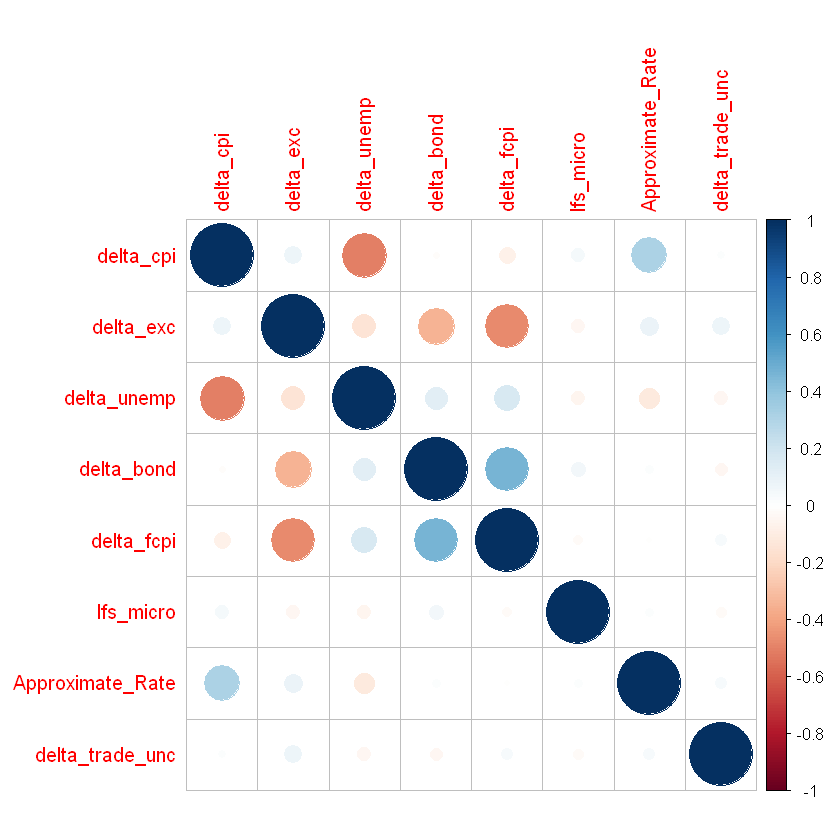

In [15]:
# Install corrplot if you don't have it
# install.packages("corrplot")
library(corrplot)

# Use the data that goes into your VAR
correlation_matrix <- cor(var_data)

# Print the matrix (values close to 1 or -1 are problems)
print(round(correlation_matrix, 2))

# Visualize the matrix to easily spot problem areas
corrplot(correlation_matrix, method = "circle")

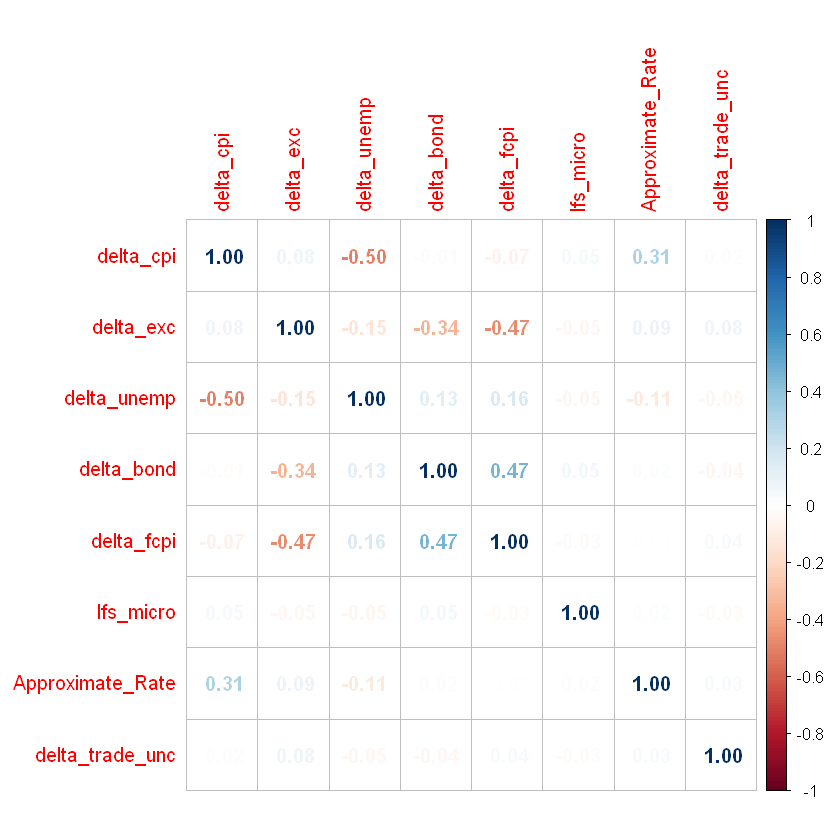

In [16]:
# Make sure your data is in a dataframe before running the VAR
# For example, let's call it 'my_var_data'

# Install corrplot if you don't have it
# install.packages("corrplot")
library(corrplot)

# Create a correlation matrix
correlation_matrix <- cor(var_data)

# Visualize the matrix to easily spot problem areas
corrplot(correlation_matrix, method = "number")

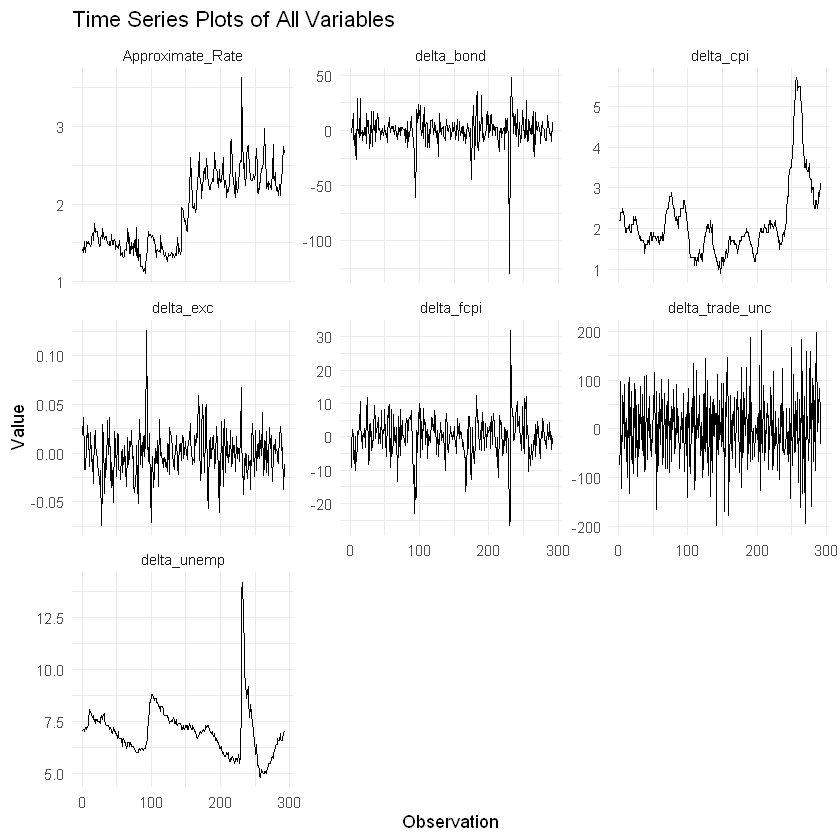

In [17]:
library(ggplot2)
library(tidyr)

# Use the dataframe that goes into your VAR
diagnostic_df <- final_monthly_df |>
  dplyr::select(
    delta_cpi, delta_exc, delta_unemp, delta_bond,
    delta_trade_unc, delta_fcpi, Approximate_Rate 
  ) |>
  tidyr::drop_na()

# Pivot to long format for easy plotting with ggplot
diagnostic_df_long <- diagnostic_df %>%
  mutate(date = 1:n()) %>% # Create a simple time index
  pivot_longer(-date, names_to = "variable", values_to = "value")

# Create the plot
ggplot(diagnostic_df_long, aes(x = date, y = value)) +
  geom_line() +
  facet_wrap(~variable, scales = "free_y") +
  theme_minimal() +
  labs(title = "Time Series Plots of All Variables", x = "Observation", y = "Value")

In [18]:
library(car)

vif_cpi <- vif(lm(delta_cpi ~ ., data = as.data.frame(var_data)))
print("VIF for delta_cpi model:")
print(vif_cpi)

# We can find the VIF for each variable by running a model where it is the dependent variable
# However, a more common way is to check the VIF of the predictors in a single model.
# Let's check the predictors for the delta_cpi equation:
model_for_vif <- lm(delta_cpi ~ ., data = as.data.frame(var_data))
print("VIF values for predictors of delta_cpi:")
print(vif(model_for_vif))

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




[1] "VIF for delta_cpi model:"
       delta_exc      delta_unemp       delta_bond       delta_fcpi 
        1.354441         1.052661         1.324185         1.524576 
       lfs_micro Approximate_Rate  delta_trade_unc 
        1.012932         1.023467         1.019057 
[1] "VIF values for predictors of delta_cpi:"
       delta_exc      delta_unemp       delta_bond       delta_fcpi 
        1.354441         1.052661         1.324185         1.524576 
       lfs_micro Approximate_Rate  delta_trade_unc 
        1.012932         1.023467         1.019057 


In [19]:
# Calculate the standard deviation for each column in your dataset
sapply(as.data.frame(var_data), sd)

delta_cpi        delta_exc      delta_unemp       delta_bond 
      0.90790775       0.02276582       1.16229031      13.66319823 
      delta_fcpi        lfs_micro Approximate_Rate  delta_trade_unc 
      6.07998498      13.10516325       0.48684167      74.56553540

In [20]:

var_model_12 <- VAR(var_data, p = 17, type = "const")

summary_12 <- summary(var_model_12)

print(summary_12$varresult$delta_cpi)


Call:
lm(formula = y ~ -1 + ., data = datamat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.199424 -0.053319  0.001154  0.057044  0.250039 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
delta_cpi.l1          1.038e+00  8.315e-02  12.482  < 2e-16 ***
delta_exc.l1          4.752e-01  5.269e-01   0.902 0.368670    
delta_unemp.l1       -1.253e-02  3.797e-02  -0.330 0.741859    
delta_bond.l1        -2.641e-03  9.692e-04  -2.725 0.007254 ** 
delta_fcpi.l1         7.229e-03  2.465e-03   2.932 0.003944 ** 
lfs_micro.l1         -6.151e-04  8.882e-04  -0.692 0.489814    
Approximate_Rate.l1   7.570e-02  8.665e-02   0.874 0.383847    
delta_trade_unc.l1    4.891e-05  1.593e-04   0.307 0.759250    
delta_cpi.l2          1.415e-01  1.205e-01   1.175 0.242204    
delta_exc.l2          4.849e-01  5.463e-01   0.888 0.376354    
delta_unemp.l2        6.501e-03  6.494e-02   0.100 0.920413    
delta_bond.l2        -1.343e-03  1.101e-03  -1.221 0.22

In [21]:
# 1. Use the predict() function to forecast 1 step (month) ahead
# The object var_model_12 already contains all the necessary data.
forecast_result <- predict(var_model_12, n.ahead = 1)

# 2. Extract the forecast for your specific variable ('delta_cpi')
#

# 2. Apply a function to each element of the forecast list to extract the 'fcst' column
point_forecasts <- sapply(forecast_result$fcst, function(x) x[, "fcst"])

# 3. Print the result
print(point_forecasts)

       delta_cpi        delta_exc      delta_unemp       delta_bond 
      2.83547364       0.03040204       6.22757715       2.53256854 
      delta_fcpi        lfs_micro Approximate_Rate  delta_trade_unc 
      6.94937632     -10.23308645       2.37471640     -27.98939210 


In [22]:
svar_order <- c("Approximate_Rate", "delta_trade_unc", "delta_exc",  "delta_bond", "delta_fcpi", 
                 "delta_unemp", "lfs_micro", "delta_cpi", "policy_rate")

# 2. Re-order your dataframe and create the time series object
svar_data <- final_monthly_df |>
  dplyr::select(all_of(svar_order)) |>
  ts(start = c(2001, 1), frequency = 12)

# 3. Re-estimate the VAR model with the ordered data
# The Cholesky decomposition is now implicitly defined by your column order
var_model_svar <- VAR(svar_data, p = 17, type = "const")

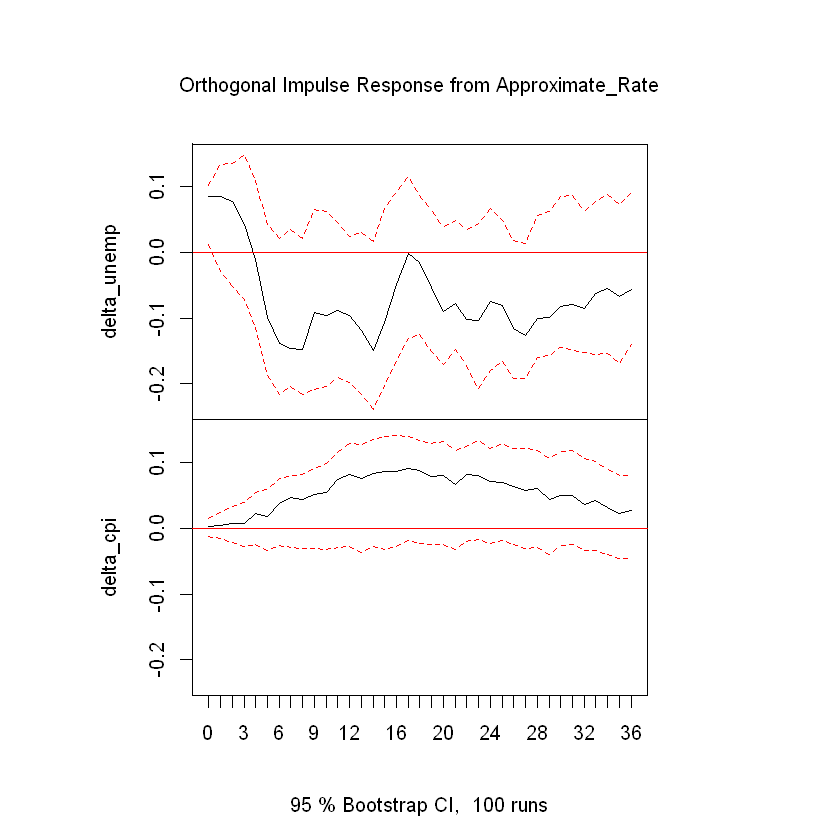

In [23]:
# Generate the IRFs for a shock to the first variable in our order ('delta_trade_unc')
svar_irf <- irf(
  var_model_svar,
  impulse = "Approximate_Rate",  # The source of the shock
  response = c("delta_cpi", "delta_unemp"), # The variables that respond
  n.ahead = 36,                 # How many months ahead to forecast
  boot = TRUE,                  # Generate bootstrap confidence intervals
  ci = 0.95                     # 95% confidence interval
)

# Plot the results
plot(svar_irf)

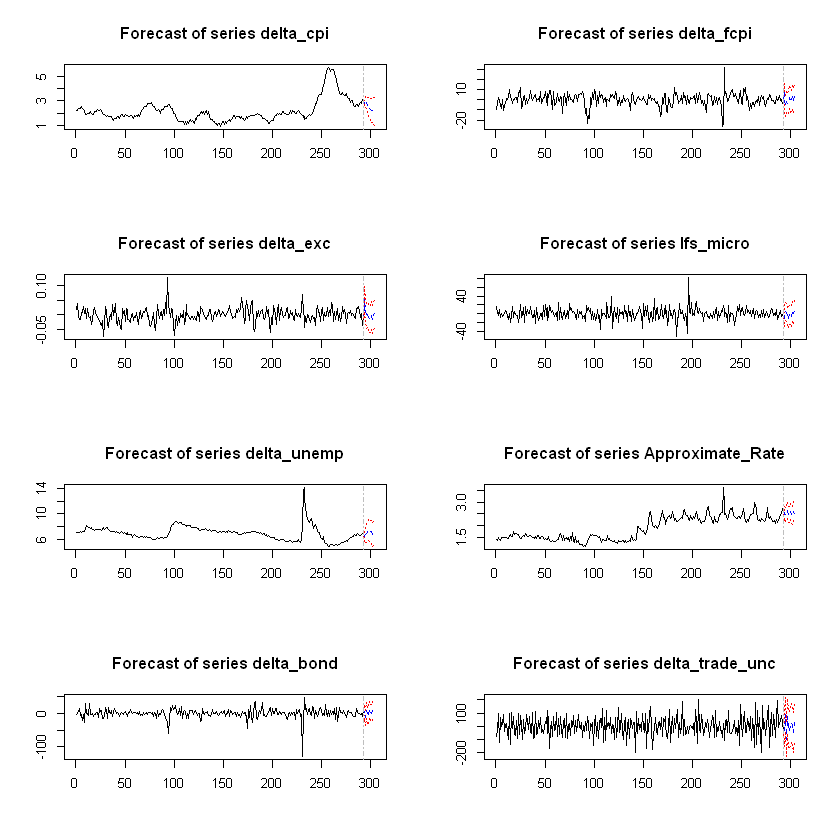

In [24]:

forecast_results <- predict(var_model_12, n.ahead = 12, ci = 0.90)

plot(forecast_results)

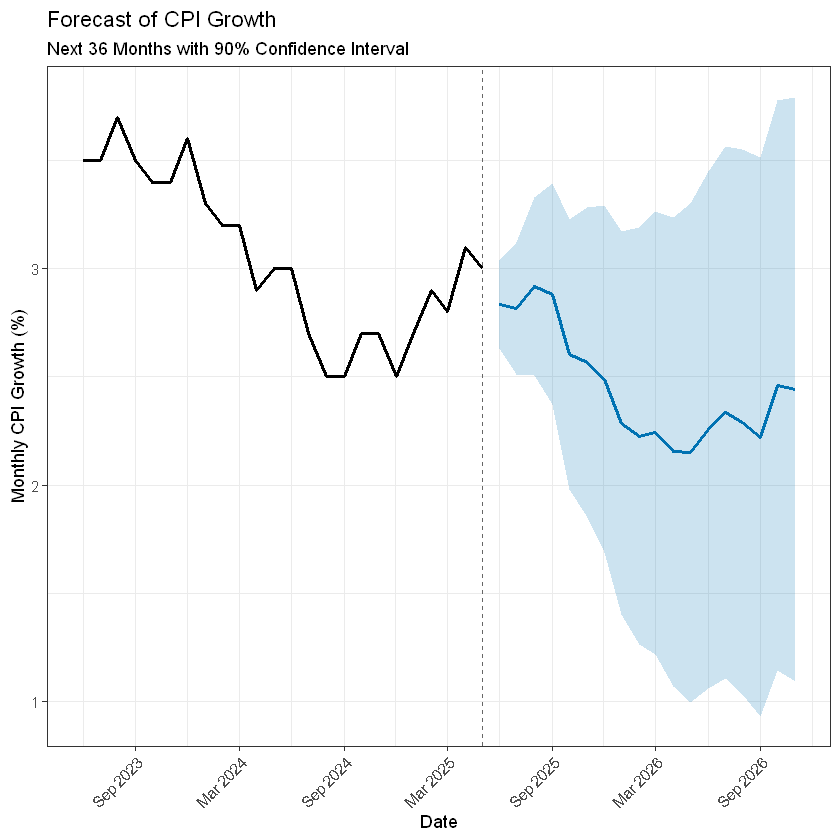

In [25]:
# --- Load required libraries ---
library(ggplot2)
library(dplyr)
library(lubridate)

# Assuming 'var_model_12' and 'final_monthly_df' are in your environment

# --- 1. Generate the forecast (your code) ---
forecast_results <- predict(var_model_12, n.ahead = 18, ci = 0.90)


# --- 2. Extract forecast data for just delta_cpi ---
# The forecast object is a list; we pull out the cpi part and convert it to a dataframe
cpi_forecast_df <- as.data.frame(forecast_results$fcst$delta_cpi)


# --- 3. Create the sequence of future dates for the x-axis ---
# Find the last date in your original data
last_date <- tail(final_monthly_df$month, 1)

# Create a sequence of 12 dates starting from the month AFTER the last date
forecast_dates <- seq.Date(from = last_date, by = "month", length.out = 19)[-1]

# Add the dates to our forecast dataframe
cpi_forecast_df$date <- forecast_dates


# --- 4. Get the last 2 years of ACTUAL data for context ---
actual_data <- final_monthly_df |>
  tail(24) |> # Get the last 24 months
  dplyr::select(date = month, actual_value = delta_cpi)


# --- 5. Create the ggplot ---
ggplot() +
  # Plot the historical actual data (as a black line)
  geom_line(data = actual_data, aes(x = date, y = actual_value), 
            linewidth = 1, color = "black") +
  
  # Plot the forecasted point estimate (as a blue line)
  geom_line(data = cpi_forecast_df, aes(x = date, y = fcst), 
            linewidth = 1, color = "#0072B2") +
  
  # Create the 90% confidence interval ribbon
  geom_ribbon(data = cpi_forecast_df, aes(x = date, ymin = lower, ymax = upper),
              alpha = 0.2, fill = "#0072B2") +
  
  # Add a vertical line to show where the forecast begins
  geom_vline(xintercept = last_date, linetype = "dashed", color = "grey40") +
  
  # Formatting and labels
  labs(
    title = "Forecast of CPI Growth",
    subtitle = "Next 36 Months with 90% Confidence Interval",
    x = "Date",
    y = "Monthly CPI Growth (%)"
  ) +
  theme_bw() +
  # Customize date formatting on the x-axis
  scale_x_date(date_breaks = "6 months", date_labels = "%b %Y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [26]:
arch_test_result <- arch.test(var_model_12, lags.multi = 5)

# Print the results
print(arch_test_result)


	ARCH (multivariate)

data:  Residuals of VAR object var_model_12
Chi-squared = 6786.4, df = 6480, p-value = 0.003958



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model_12
Chi-squared = 6786.4, df = 6480, p-value = 0.003958



In [27]:

# Check the stability of the model
# All roots should be < 1
roots(var_model_12)

[1] 0.9929786 0.9817813 0.9817813 0.9775693 0.9775693 0.9754055 0.9754055
  [8] 0.9723180 0.9723180 0.9720812 0.9720812 0.9710981 0.9710981 0.9709424
 [15] 0.9709424 0.9705757 0.9705757 0.9700592 0.9700592 0.9688176 0.9688176
 [22] 0.9686505 0.9686505 0.9677913 0.9653191 0.9653191 0.9630478 0.9630478
 [29] 0.9610172 0.9610172 0.9595654 0.9595654 0.9591397 0.9591397 0.9571922
 [36] 0.9571922 0.9521194 0.9521194 0.9516783 0.9516783 0.9510226 0.9510226
 [43] 0.9495901 0.9495901 0.9481892 0.9481892 0.9479015 0.9479015 0.9474974
 [50] 0.9474974 0.9473739 0.9473739 0.9457818 0.9457818 0.9433028 0.9430582
 [57] 0.9430582 0.9427111 0.9427111 0.9423505 0.9423505 0.9422860 0.9422860
 [64] 0.9379719 0.9379719 0.9376209 0.9376209 0.9355220 0.9355220 0.9343464
 [71] 0.9343464 0.9336546 0.9336546 0.9312608 0.9312608 0.9307717 0.9307717
 [78] 0.9303032 0.9303032 0.9300129 0.9300129 0.9299653 0.9299653 0.9299152
 [85] 0.9299152 0.9293404 0.9293404 0.9288826 0.9288826 0.9275360 0.9275360
 [92] 0.9186649 0.9186649 0.9129860 0.9129860 0.9126958 0.9126958 0.9112255
 [99] 0.9112255 0.9071841 0.9071841 0.9048801 0.9048801 0.8955741 0.8955741
[106] 0.8943082 0.8943082 0.8920841 0.8920841 0.8824322 0.8824322 0.8799448
[113] 0.8799448 0.8727382 0.8727382 0.8717306 0.8717306 0.8710148 0.8710148
[120] 0.8473342 0.8473342 0.8234544 0.8234544 0.8092261 0.8092261 0.7956553
[127] 0.7327749 0.7327749 0.7243743 0.7243743 0.6662894 0.6662894 0.6638273
[134] 0.6638273 0.3487686 0.3487686

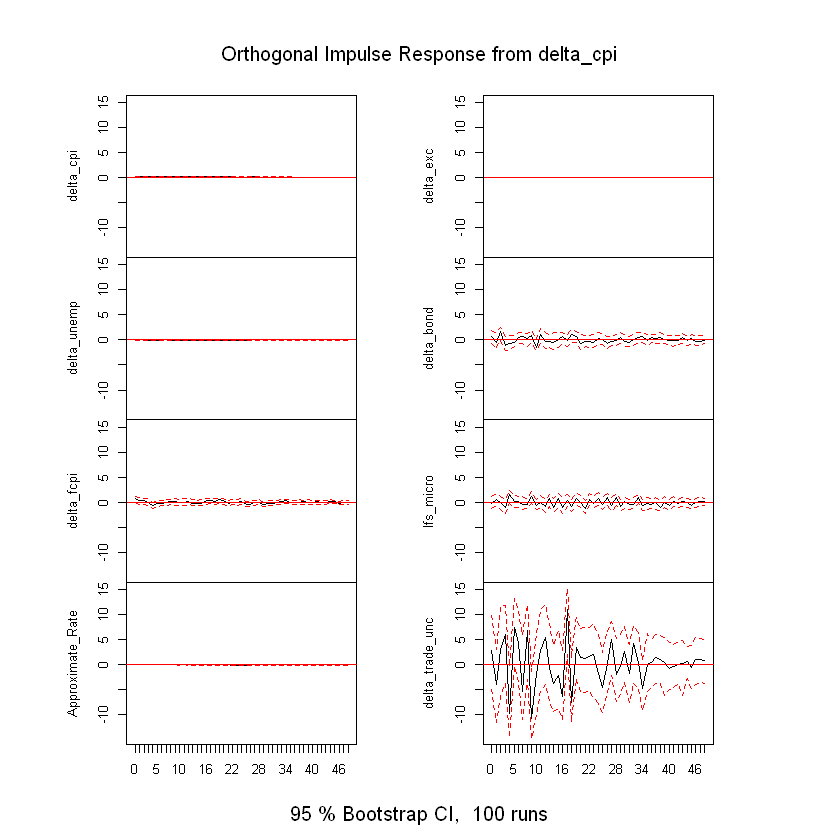

In [28]:
irf_increase <- vars::irf(var_model_12,
                    impulse = "delta_cpi",
                    n.ahead = 48,
                    boot = TRUE)

# Plot the results
plot(irf_increase)